In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

<ipython-input-3-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-3-cbe8f7c99398>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


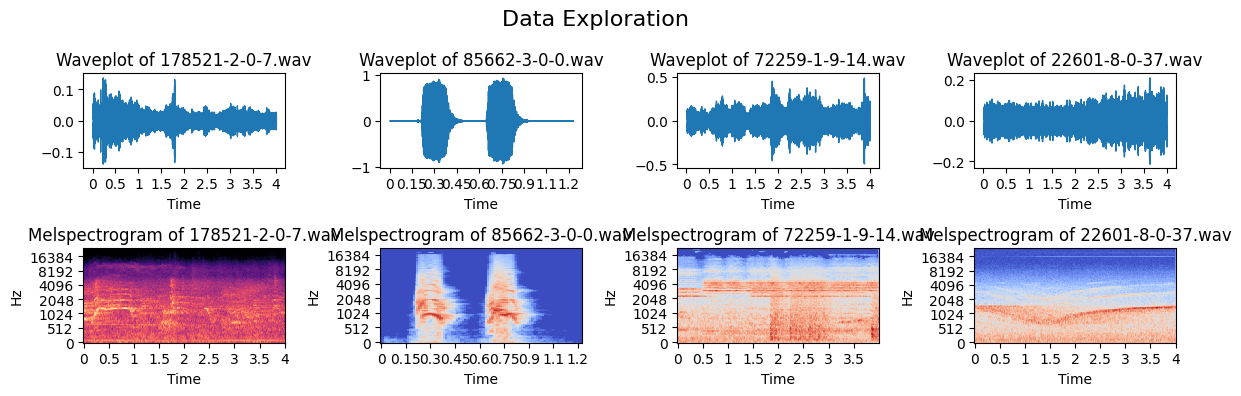

In [ ]:
visualize_class = ['children_playing', 'dog_bark', 'car_horn', 'siren']

description = pd.read_csv('/content/drive/MyDrive/project/UrbanSound8K.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_class)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(12, 4)
for i, digit in enumerate(visualize_class):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['class'] == digit]['slice_file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/project/rec', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_class)])
    axs[i+len(visualize_class)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
import os
from tqdm import tqdm
import librosa
import numpy as np

feature_list = []
label_list = []

# Iterate over all files in the given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/project/rec')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/project/rec', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)

    # Ensure all mel spectrograms have the same number of columns (e.g., 87)
    max_columns = 87
    if mels_db.shape[1] < max_columns:
        # If fewer columns, pad with zeros
        mels_db = np.pad(mels_db, ((0, 0), (0, max_columns - mels_db.shape[1])))
    elif mels_db.shape[1] > max_columns:
        # If more columns, truncate
        mels_db = mels_db[:, :max_columns]

    # Reshape it according to the maximum number of columns
    feature_list.append(mels_db.reshape((128, -1, 1)))
    label_list.append(file[0])

features = np.array(feature_list)
labels = np.array(label_list)


Preparing feature dataset and labels.


100%|██████████| 8742/8742 [15:20<00:00,  9.50it/s]


In [ ]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(10, activation=keras.activations.softmax)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 87, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 43, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 43, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 21, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 21504)             0         
                                                                 
 dropout (Dropout)           (None, 21504)             0

Epoch 1/10
67/67 [==============================] - 54s 780ms/step - loss: 3.5375 - accuracy: 0.5592 - val_loss: 1.4487 - val_accuracy: 0.5910
Epoch 2/10
67/67 [==============================] - 42s 623ms/step - loss: 1.2948 - accuracy: 0.6257 - val_loss: 1.3415 - val_accuracy: 0.6198
Epoch 3/10
67/67 [==============================] - 48s 721ms/step - loss: 1.0896 - accuracy: 0.6794 - val_loss: 1.2532 - val_accuracy: 0.6498
Epoch 4/10
67/67 [==============================] - 41s 611ms/step - loss: 0.9285 - accuracy: 0.7189 - val_loss: 1.1755 - val_accuracy: 0.6629
Epoch 5/10
67/67 [==============================] - 40s 606ms/step - loss: 0.7353 - accuracy: 0.7719 - val_loss: 1.1791 - val_accuracy: 0.6748
Epoch 6/10
67/67 [==============================] - 47s 705ms/step - loss: 0.5977 - accuracy: 0.8146 - val_loss: 1.2105 - val_accuracy: 0.6857
Epoch 7/10
67/67 [==============================] - 42s 631ms/step - loss: 0.4918 - accuracy: 0.8492 - val_loss: 1.2452 - val_accuracy: 0.6912

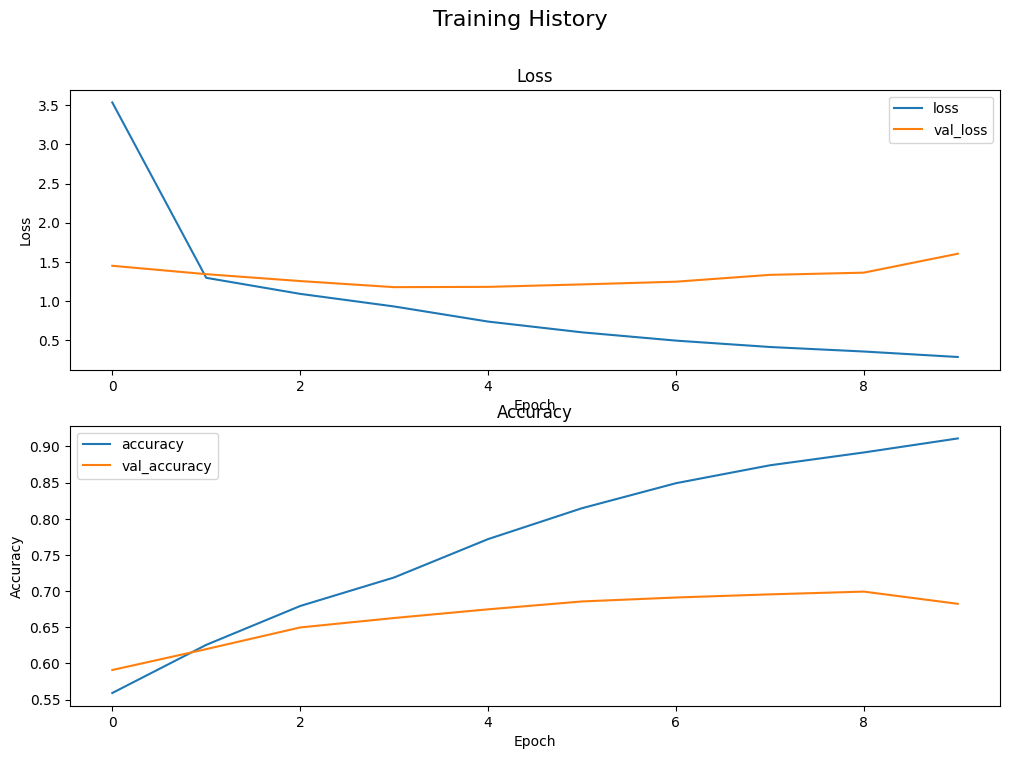

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 10

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

82/82 [==============================] - 12s 146ms/step


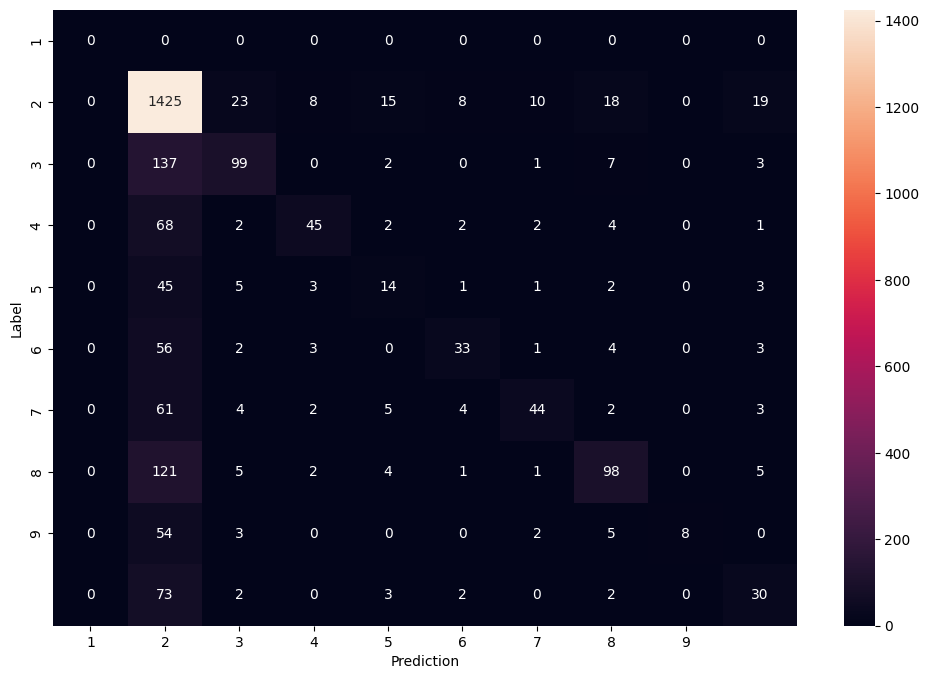

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()